# TP3: Generative Probabilistic Models

**IFT6390 - Fundamentals of Machine Learning**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pierrelux/mlbook/blob/main/exercises/tp3_probabilistic_models.ipynb)

This notebook accompanies [Chapter 6: Generative Probabilistic Models](https://pierrelux.github.io/mlbook/ch6_probabilistic_models).

## Objectives

By the end of this practical exercise, you will be able to:
- Estimate the parameters of a naive Bayes classifier by maximum likelihood
- Apply Laplace smoothing to avoid zero probabilities
- Implement prediction in log-space for numerical stability
- Compute the multivariate Gaussian density
- Implement the EM algorithm for a Gaussian mixture model
- Compare soft clustering (GMM) and hard clustering (k-means)

This practical exercise implements **everything from scratch**, without using scikit-learn for training. Scikit-learn is only used to load data and for a final comparison.

---

## Part 0: Setup

Run this cell to import the necessary libraries.

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# For nice plots
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 12

print("Setup complete!")

Setup complete!


---
## Part 1: Text Classification Data

The naive Bayes classifier is especially popular for **text classification**. We use a subset of the **20 Newsgroups** dataset, which contains discussion forum posts grouped by topic.

Our task: distinguish posts about **medicine** from those about **electronics**, based on the words they contain.

In [48]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# Load two categories
categories = ['sci.electronics', 'sci.med']
newsgroups = fetch_20newsgroups(subset='all', categories=categories,
                                shuffle=True, random_state=42)

# Class names
class_names = ['Electronics', 'Medicine']

# Convert texts to word count matrix
vectorizer = CountVectorizer(max_features=2000, stop_words='english')
X_counts = vectorizer.fit_transform(newsgroups.data).toarray()
y = newsgroups.target
vocabulary = vectorizer.get_feature_names_out()

print(f"Number of documents: {len(y)}")
print(f"Classes: {newsgroups.target_names}")
print(f"Count matrix: {X_counts.shape} ({X_counts.shape[0]} documents × {X_counts.shape[1]} words)")
print(f"\nExample — first 10 words in vocabulary: {list(vocabulary[:10])}")
print(f"Corresponding counts (document 0): {X_counts[0, :10]}")

Number of documents: 1974
Classes: ['sci.electronics', 'sci.med']
Count matrix: (1974, 2000) (1974 documents × 2000 words)

Example — first 10 words in vocabulary: ['00', '000', '02', '03', '04', '09', '10', '100', '1000', '11']
Corresponding counts (document 0): [0 0 0 0 0 0 0 0 0 0]


In [49]:
# Train / test split (80% / 20%)
np.random.seed(42)
n = len(y) # number of documents
indices = np.random.permutation(n)
n_train = int(0.8 * n) # 80% of docs

train_idx = indices[:n_train]
test_idx = indices[n_train:]

X_train, y_train = X_counts[train_idx], y[train_idx]
X_test, y_test = X_counts[test_idx], y[test_idx]

print(f"Training: {len(X_train)} documents")
print(f"Test: {len(X_test)} documents")
print("\nDistribution (training):")
for c in [0, 1]:
    print(f"  {class_names[c]}: {np.sum(y_train == c)} documents ({np.mean(y_train == c):.1%})")

Training: 1579 documents
Test: 395 documents

Distribution (training):
  Electronics: 773 documents (49.0%)
  Medicine: 806 documents (51.0%)


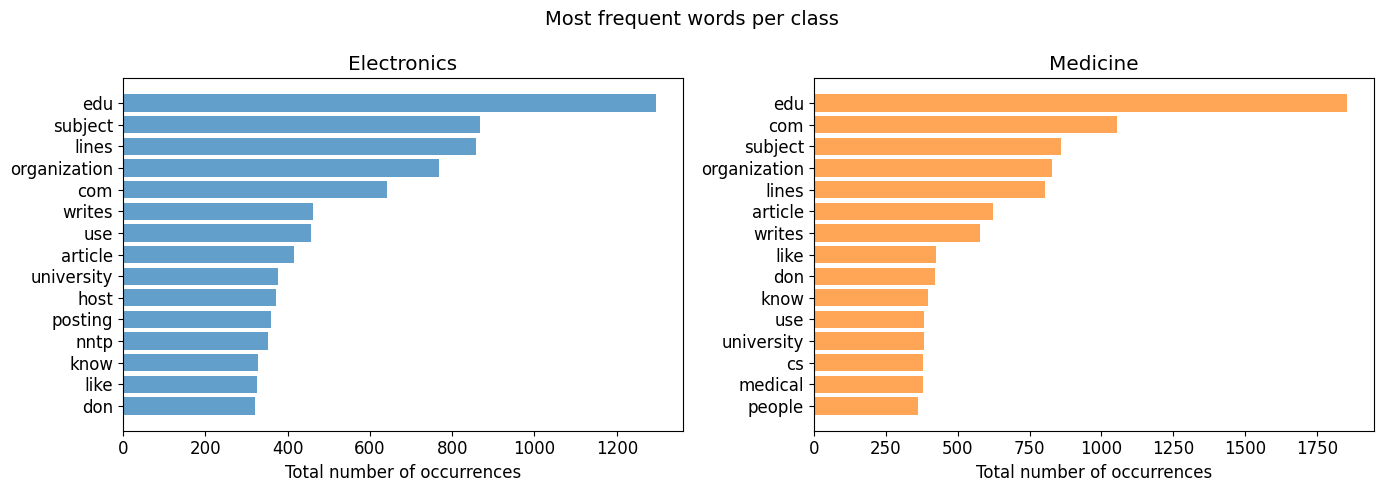

In [50]:
# Most frequent words per class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for c, ax in enumerate(axes):
    mask = y_train == c # mask by category
    word_counts = X_train[mask].sum(axis=0) # sum word occurrences across samples
    top_indices = np.argsort(word_counts)[-15:] # get idx of highest counts

    ax.barh(range(15), word_counts[top_indices], color=f'C{c}', alpha=0.7)
    ax.set_yticks(range(15))
    ax.set_yticklabels([vocabulary[i] for i in top_indices])
    ax.set_xlabel("Total number of occurrences")
    ax.set_title(f'{class_names[c]}')

plt.suptitle('Most frequent words per class', fontsize=14)
plt.tight_layout()
plt.show()

---
## Part 2: The Naive Bayes Classifier

The naive Bayes classifier assumes that words appear **independently** of each other, given the class. For text classification with word counts, we use the **multinomial** model:

$$\hat{y} = \arg\max_c \left[ \log \pi_c + \sum_{d=1}^{D} x_d \log \theta_{dc} \right]$$

where:
- $\pi_c = p(y = c)$ is the prior probability of class $c$
- $\theta_{dc} = p(\text{word } d \mid y = c)$ is the probability of word $d$ in class $c$
- $x_d$ is the number of occurrences of word $d$ in the document

### Exercise 1: Estimate class priors ★

The first step is to estimate the prior probabilities $\pi_c$. The maximum likelihood estimator is the frequency of each class:

$$\hat{\pi}_c = \frac{N_c}{N}$$

We work in log-space for numerical stability. Complete the function below.

In [51]:
def estimate_log_priors(y_train):
    """
    Estimate the log prior probabilities of each class.

    Args:
        y_train: training labels (N,)

    Returns:
        log_priors: array of size (C,) containing log(pi_c) for each class
    """
    _, counts = np.unique(y_train, return_counts=True)
    N = len(y_train)
    
    # ============================================
    # TODO: Compute the log prior probabilities
    # Hint: log(N_c / N) for each class c
    # ============================================

    log_priors = np.log(counts / N)  # <- Replace with your code

    return log_priors

In [52]:
# Test your function
log_priors = estimate_log_priors(y_train)

if log_priors is not None:
    for c in range(len(log_priors)):
        print(f"log pi({class_names[c]}) = {log_priors[c]:.4f}  ->  pi = {np.exp(log_priors[c]):.4f}")

    # Check: probabilities must sum to 1
    if np.isclose(np.sum(np.exp(log_priors)), 1.0):
        print("\nCorrect! The probabilities sum to 1.")
    else:
        print("\nCheck your implementation.")
else:
    print("Complete the estimate_log_priors function!")

log pi(Electronics) = -0.7143  ->  pi = 0.4896
log pi(Medicine) = -0.6725  ->  pi = 0.5104

Correct! The probabilities sum to 1.


<details>
<summary><b>Solution</b> (click to reveal)</summary>

```python
def estimate_log_priors(y_train):
    classes = np.unique(y_train)
    N = len(y_train)
    log_priors = np.array([np.log(np.sum(y_train == c) / N) for c in classes])
    return log_priors
```
</details>

### Exercise 2: Estimate conditional probabilities ★

For the multinomial model, the probability of word $d$ in class $c$ is estimated by:

$$\hat{\theta}_{dc} = \frac{N_{dc} + \alpha}{N_c^{\text{words}} + \alpha V}$$

where:
- $N_{dc}$ = total number of occurrences of word $d$ in documents of class $c$
- $N_c^{\text{words}} = \sum_d N_{dc}$ = total number of words in class $c$
- $V$ = vocabulary size
- $\alpha$ = Laplace smoothing parameter ($\alpha = 1$ by default)

Laplace smoothing prevents zero probabilities: without it, a single absent word would be enough to eliminate a class.

In [53]:
def estimate_log_likelihoods(X_train, y_train, alpha=1.0):
    """
    Estimate the log conditional probabilities of each word per class.

    Args:
        X_train: count matrix (N, D)
        y_train: labels (N,)
        alpha: Laplace smoothing parameter

    Returns:
        log_likelihoods: matrix (C, D) where entry [c, d] = log(theta_dc)
    """
    classes = np.unique(y_train)
    C = len(classes)
    D = X_train.shape[1]
    V = D  # vocabulary size

    log_likelihoods = np.zeros((C, D))

    for c in classes:
        # Documents of class c
        X_c = X_train[y_train == c]

        # ============================================
        # TODO: Compute the log conditional probabilities
        # 1. N_dc = X_c.sum(axis=0)  (occurrences of each word)
        # 2. N_c_words = N_dc.sum()  (total words in the class)
        # 3. theta_dc = (N_dc + alpha) / (N_c_words + alpha * V)
        # 4. log_likelihoods[c] = np.log(theta_dc)
        # ============================================
        N_dc = X_c.sum(axis=0) # occur. of words in class
        N_c_words = N_dc.sum() # number of words in the class
        theta_dc = (N_dc + alpha) / (N_c_words + alpha * V)
        log_likelihoods[c] = np.log(theta_dc)  # <- Replace with your code

    return log_likelihoods

In [54]:
# Test your function
log_lk = estimate_log_likelihoods(X_train, y_train, alpha=1.0)

if log_lk is not None and not np.any(log_lk == 0):
    print(f"Matrix shape: {log_lk.shape} (classes × words)")

    for c in range(2):
        prob_sum = np.exp(log_lk[c]).sum()
        print(f"\nClass {class_names[c]}:")
        print(f"  Sum of probabilities: {prob_sum:.4f} (expected: ≈ 1.0)")

        top5 = np.argsort(log_lk[c])[-5:][::-1]
        print(f"  Top 5 words: {[vocabulary[i] for i in top5]}")

    if all(np.isclose(np.exp(log_lk[c]).sum(), 1.0, atol=1e-5) for c in range(2)):
        print("\nCorrect!")
else:
    print("Complete the estimate_log_likelihoods function!")

Matrix shape: (2, 2000) (classes × words)

Class Electronics:
  Sum of probabilities: 1.0000 (expected: ≈ 1.0)
  Top 5 words: ['edu', 'subject', 'lines', 'organization', 'com']

Class Medicine:
  Sum of probabilities: 1.0000 (expected: ≈ 1.0)
  Top 5 words: ['edu', 'com', 'subject', 'organization', 'lines']

Correct!


<details>
<summary><b>Solution</b> (click to reveal)</summary>

```python
def estimate_log_likelihoods(X_train, y_train, alpha=1.0):
    classes = np.unique(y_train)
    C = len(classes)
    D = X_train.shape[1]
    V = D

    log_likelihoods = np.zeros((C, D))

    for c in classes:
        X_c = X_train[y_train == c]
        N_dc = X_c.sum(axis=0)
        N_c_words = N_dc.sum()
        theta_dc = (N_dc + alpha) / (N_c_words + alpha * V)
        log_likelihoods[c] = np.log(theta_dc)

    return log_likelihoods
```
</details>

### Exercise 3: Predict with naive Bayes ★★

To classify a document, we compute the score of each class and choose the most probable one:

$$\hat{y} = \arg\max_c \left[ \log \pi_c + \sum_{d=1}^{D} x_d \log \theta_{dc} \right]$$

In matrix form: $\text{scores} = \mathbf{X} \cdot \log\boldsymbol{\Theta}^\top + \log\boldsymbol{\pi}$

Computing in log-space avoids numerical underflow problems: the product of thousands of probabilities close to zero would yield a result indistinguishable from zero in floating-point arithmetic.

In [55]:
def predict_naive_bayes(X, log_priors, log_likelihoods):
    """
    Predict classes with the naive Bayes classifier.

    Args:
        X: count matrix (N, D)
        log_priors: log prior probabilities (C,)
        log_likelihoods: log conditional probabilities (C, D)

    Returns:
        predictions: predicted classes (N,)
        log_scores: score matrix (N, C)
    """
    # ============================================
    # TODO: Compute the log scores for each class
    # scores = X @ log_likelihoods.T + log_priors
    # predictions = argmax of scores per row
    # ============================================

    log_scores = X @ log_likelihoods.T + log_priors  # <- Replace with your code
    predictions = np.argmax(log_scores, axis=1)  # <- Replace with your code

    return predictions, log_scores

In [56]:
# Test your function
if log_priors is not None and log_lk is not None and not np.any(log_lk == 0):
    y_pred, scores = predict_naive_bayes(X_test, log_priors, log_lk)

    if y_pred is not None:
        accuracy = np.mean(y_pred == y_test)
        print(f"Test accuracy: {accuracy:.1%}")

        print("\nConfusion matrix:")
        for c_true in [0, 1]:
            for c_pred in [0, 1]:
                count = np.sum((y_test == c_true) & (y_pred == c_pred))
                print(f"  True={class_names[c_true]:15s} Predicted={class_names[c_pred]:15s} : {count}")

        if accuracy > 0.85:
            print(f"\nCorrect! The classifier achieves {accuracy:.1%} accuracy.")
    else:
        print("Complete the predict_naive_bayes function!")
else:
    print("Complete the previous functions first!")

Test accuracy: 97.2%

Confusion matrix:
  True=Electronics     Predicted=Electronics     : 211
  True=Electronics     Predicted=Medicine        : 0
  True=Medicine        Predicted=Electronics     : 11
  True=Medicine        Predicted=Medicine        : 173

Correct! The classifier achieves 97.2% accuracy.


<details>
<summary><b>Solution</b> (click to reveal)</summary>

```python
def predict_naive_bayes(X, log_priors, log_likelihoods):
    log_scores = X @ log_likelihoods.T + log_priors
    predictions = np.argmax(log_scores, axis=1)
    return predictions, log_scores
```
</details>

### Exercise 4: Interpret the classifier ★

An advantage of naive Bayes: we can identify the most **discriminative** words for each class. The log-probability ratio $\log \theta_{d,c=1} - \log \theta_{d,c=0}$ indicates how strongly a word is associated with one class over the other.

Complete the function below.

In [57]:
def most_discriminative_words(log_likelihoods, vocabulary, class_names, n_top=10):
    """
    Find the most discriminative words for each class.

    Args:
        log_likelihoods: log conditional probabilities (C, D)
        vocabulary: array of words (D,)
        class_names: list of class names
        n_top: number of words to display per class
    """
    # ============================================
    # TODO: Compute the ratio log(theta_d,c=1) - log(theta_d,c=0)
    # Words with the largest ratios favor class 1
    # Words with the smallest ratios favor class 0
    # ============================================

    log_ratio = log_likelihoods[1, :] - log_likelihoods[0, :]  # <- Replace with your code

    if log_ratio is not None:
        top_class1 = np.argsort(log_ratio)[-n_top:][::-1]
        top_class0 = np.argsort(log_ratio)[:n_top]

        print(f"Words most associated with '{class_names[1]}':")
        for i in top_class1:
            print(f"  {vocabulary[i]:20s}  ratio = {log_ratio[i]:+.2f}")

        print(f"\nWords most associated with '{class_names[0]}':")
        for i in top_class0:
            print(f"  {vocabulary[i]:20s}  ratio = {log_ratio[i]:+.2f}")

In [58]:
# Run the interpretation
if log_lk is not None and not np.any(log_lk == 0):
    most_discriminative_words(log_lk, vocabulary, class_names)
else:
    print("Complete the previous functions first!")

Words most associated with 'Medicine':
  disease               ratio = +5.50
  patients              ratio = +5.23
  banks                 ratio = +5.14
  cancer                ratio = +5.14
  treatment             ratio = +5.10
  geb                   ratio = +5.09
  diet                  ratio = +5.03
  candida               ratio = +4.97
  health                ratio = +4.85
  yeast                 ratio = +4.84

Words most associated with 'Electronics':
  circuit               ratio = -5.66
  wire                  ratio = -5.58
  wiring                ratio = -5.31
  amp                   ratio = -5.01
  batteries             ratio = -4.75
  outlets               ratio = -4.54
  audio                 ratio = -4.50
  radar                 ratio = -4.43
  gfci                  ratio = -4.40
  cooling               ratio = -4.38


<details>
<summary><b>Solution</b> (click to reveal)</summary>

```python
def most_discriminative_words(log_likelihoods, vocabulary, class_names, n_top=10):
    log_ratio = log_likelihoods[1] - log_likelihoods[0]

    top_class1 = np.argsort(log_ratio)[-n_top:][::-1]
    top_class0 = np.argsort(log_ratio)[:n_top]

    print(f"Words most associated with '{class_names[1]}':")
    for i in top_class1:
        print(f"  {vocabulary[i]:20s}  ratio = {log_ratio[i]:+.2f}")

    print(f"\nWords most associated with '{class_names[0]}':")
    for i in top_class0:
        print(f"  {vocabulary[i]:20s}  ratio = {log_ratio[i]:+.2f}")
```
</details>

### Comparison with scikit-learn

Let's verify that our implementation gives results similar to scikit-learn.

In [59]:
from sklearn.naive_bayes import MultinomialNB

if 'y_pred' in dir() and y_pred is not None:
    clf = MultinomialNB(alpha=1.0)
    clf.fit(X_train, y_train)

    accuracy_sklearn = clf.score(X_test, y_test)
    y_pred_sklearn = clf.predict(X_test)

    print("Accuracy comparison:")
    print(f"  Our implementation: {np.mean(y_pred == y_test):.1%}")
    print(f"  Scikit-learn:       {accuracy_sklearn:.1%}")

    agreement = np.mean(y_pred == y_pred_sklearn)
    print(f"\nPrediction agreement: {agreement:.1%}")
else:
    print("Complete the previous functions first!")

Accuracy comparison:
  Our implementation: 97.2%
  Scikit-learn:       97.2%

Prediction agreement: 100.0%


---
## Part 3: Latent Variables and Gaussian Mixture Models

Let's move from supervised classification to **unsupervised clustering**. A Gaussian mixture model (GMM) assumes that the data is generated by $K$ Gaussian distributions:

$$p(\mathbf{x} \mid \boldsymbol{\theta}) = \sum_{k=1}^K \pi_k \, \mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$

A **latent variable** $z \in \{1, \ldots, K\}$ indicates which component each observation comes from. The EM algorithm estimates the parameters by alternating between computing the **responsibilities** (soft membership probabilities) and updating the parameters.

We work with synthetic 2D data so we can visualize each step.

In [60]:
# Generate data from 3 Gaussian components
np.random.seed(42)

# True parameters (unknown to the algorithm)
true_means = [np.array([0, 0]), np.array([5, 0]), np.array([2.5, 4])]
true_covs = [
    np.array([[1.0, 0.3], [0.3, 1.0]]),
    np.array([[1.5, -0.5], [-0.5, 0.5]]),
    np.array([[0.5, 0.0], [0.0, 2.0]])
]
true_weights = [0.3, 0.4, 0.3]
n_total = 450

# Generate the data
X_gmm = []
z_true = []
for k in range(3):
    n_k = int(true_weights[k] * n_total)
    X_gmm.append(np.random.multivariate_normal(true_means[k], true_covs[k], n_k))
    z_true.extend([k] * n_k)

X_gmm = np.vstack(X_gmm)
z_true = np.array(z_true)

# Shuffle the data
shuffle_idx = np.random.permutation(len(X_gmm))
X_gmm = X_gmm[shuffle_idx]
z_true = z_true[shuffle_idx]

print(f"Number of points: {len(X_gmm)}")
print(f"Dimensions: {X_gmm.shape[1]}")

Number of points: 450
Dimensions: 2


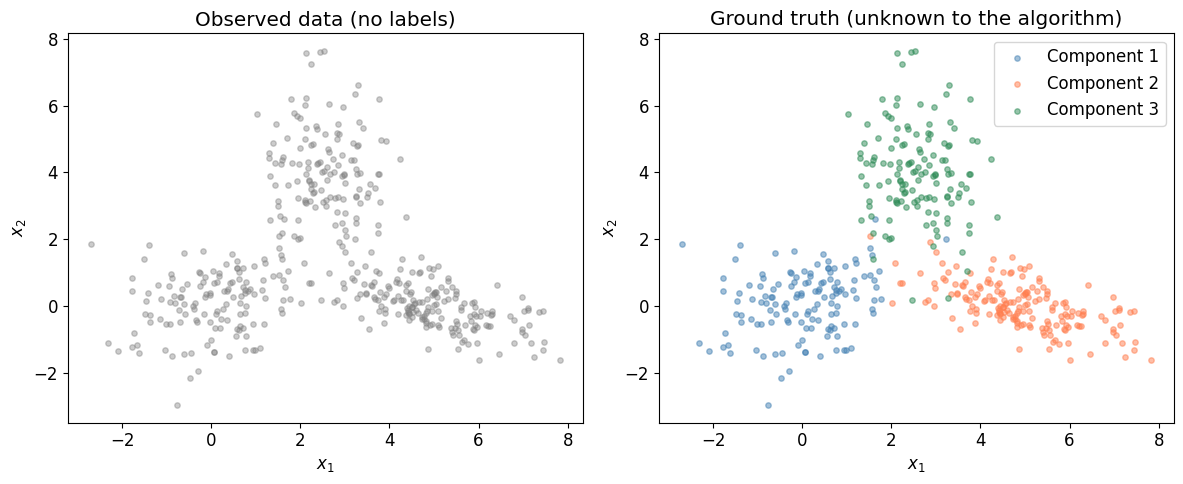

In [61]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.scatter(X_gmm[:, 0], X_gmm[:, 1], c='gray', alpha=0.4, s=15)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Observed data (no labels)')

ax = axes[1]
colors_true = ['steelblue', 'coral', 'seagreen']
for k in range(3):
    mask = z_true == k
    ax.scatter(X_gmm[mask, 0], X_gmm[mask, 1], c=colors_true[k], alpha=0.5,
               s=15, label=f'Component {k+1}')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title("Ground truth (unknown to the algorithm)")
ax.legend()

plt.tight_layout()
plt.show()

### Exercise 5: Compute the multivariate Gaussian density ★

The density of a multivariate Gaussian is:

$$\mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{D/2} |\boldsymbol{\Sigma}|^{1/2}} \exp\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right)$$

The term $(\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})$ is the squared **Mahalanobis distance**.

In [62]:
def gaussian_pdf(X, mu, Sigma):
    """
    Compute the multivariate Gaussian density for each point.

    Args:
        X: data (N, D)
        mu: mean (D,)
        Sigma: covariance matrix (D, D)

    Returns:
        densities: densities (N,)
    """
    N, D = X.shape

    # ============================================
    # TODO: Compute the Gaussian density
    # 1. diff = X - mu                        (N, D)
    # 2. Sigma_inv = np.linalg.inv(Sigma)      (D, D)
    # 3. mahal = np.sum(diff @ Sigma_inv * diff, axis=1)  (N,)
    # 4. norm = 1 / sqrt((2*pi)^D * det(Sigma))
    # 5. densities = norm * exp(-0.5 * mahal)
    # ============================================
    
    diff = X - mu
    Sigma_inv = np.linalg.inv(Sigma)
    mahal = np.sum(diff @ Sigma_inv * diff, axis=1)
    norm = 1.0 / np.sqrt((2 * np.pi) ** D * np.linalg.det(Sigma))
    densities = norm * np.exp(-0.5 * mahal) 

    return densities

In [63]:
# Test: compare with scipy
from scipy.stats import multivariate_normal

test_pdf = gaussian_pdf(X_gmm[:2], np.array([0, 0]), np.eye(2))

if test_pdf is not None:
    mu_test = np.array([1.0, 2.0])
    Sigma_test = np.array([[1.0, 0.3], [0.3, 0.5]])

    our_result = gaussian_pdf(X_gmm[:5], mu_test, Sigma_test)
    scipy_result = multivariate_normal.pdf(X_gmm[:5], mean=mu_test, cov=Sigma_test)

    print("Comparison with scipy.stats:")
    for i in range(5):
        print(f"  Point {i}: ours = {our_result[i]:.6f}, scipy = {scipy_result[i]:.6f}")

    if np.allclose(our_result, scipy_result, atol=1e-10):
        print("\nCorrect!")
    else:
        print("\nCheck your implementation.")
else:
    print("Complete the gaussian_pdf function!")

Comparison with scipy.stats:
  Point 0: ours = 0.046075, scipy = 0.046075
  Point 1: ours = 0.002543, scipy = 0.002543
  Point 2: ours = 0.000000, scipy = 0.000000
  Point 3: ours = 0.057366, scipy = 0.057366
  Point 4: ours = 0.000023, scipy = 0.000023

Correct!


<details>
<summary><b>Solution</b> (click to reveal)</summary>

```python
def gaussian_pdf(X, mu, Sigma):
    N, D = X.shape
    diff = X - mu
    Sigma_inv = np.linalg.inv(Sigma)
    mahal = np.sum(diff @ Sigma_inv * diff, axis=1)
    norm = 1.0 / np.sqrt((2 * np.pi) ** D * np.linalg.det(Sigma))
    densities = norm * np.exp(-0.5 * mahal)
    return densities
```
</details>

### Exercise 6: Compute the responsibilities (E-step) ★★

The **E-step** computes the responsibilities — the posterior probability that each point comes from each component:

$$r_{nk} = \frac{\pi_k \, \mathcal{N}(\mathbf{x}_n \mid \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \, \mathcal{N}(\mathbf{x}_n \mid \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$

The responsibilities are values in $[0, 1]$ that sum to 1 for each point. This is **soft clustering**.

In [64]:
def e_step(X, weights, means, covariances):
    """
    E-step: compute the responsibilities.

    Args:
        X: data (N, D)
        weights: mixture weights (K,)
        means: list of K means (each of dimension D)
        covariances: list of K covariance matrices (each D×D)

    Returns:
        responsibilities: matrix (N, K) of responsibilities
    """
    N = X.shape[0]
    K = len(weights)

    # ============================================
    # TODO: Compute the responsibilities
    # 1. For each component k:
    #    weighted_pdf[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])
    # 2. Normalize each row:
    #    responsibilities = weighted_pdf / weighted_pdf.sum(axis=1, keepdims=True)
    # ============================================
    
    weighted_pdf = np.zeros((N, K))
    for k in range(K):
        weighted_pdf[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])

    responsibilities = weighted_pdf / weighted_pdf.sum(axis=1, keepdims=True)

    return responsibilities

In [65]:
# Test with the true parameters
test_pdf = gaussian_pdf(X_gmm[:2], np.array([0, 0]), np.eye(2))

if test_pdf is not None:
    r_test = e_step(X_gmm, np.array(true_weights), true_means, true_covs)

    if r_test is not None:
        print(f"Responsibilities shape: {r_test.shape}")
        print(f"Row sums (first 5, expected: 1.0): {r_test[:5].sum(axis=1).round(4)}")
        print(f"\nResponsibilities (first 5 points):")
        print(r_test[:5].round(3))

        if np.allclose(r_test.sum(axis=1), 1.0):
            print("\nCorrect! Responsibilities sum to 1 for each point.")
    else:
        print("Complete the e_step function!")
else:
    print("Complete gaussian_pdf first!")

Responsibilities shape: (450, 3)
Row sums (first 5, expected: 1.0): [1. 1. 1. 1. 1.]

Responsibilities (first 5 points):
[[0.002 0.    0.997]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [0.004 0.    0.996]
 [0.    0.    1.   ]]

Correct! Responsibilities sum to 1 for each point.


<details>
<summary><b>Solution</b> (click to reveal)</summary>

```python
def e_step(X, weights, means, covariances):
    N = X.shape[0]
    K = len(weights)

    weighted_pdf = np.zeros((N, K))
    for k in range(K):
        weighted_pdf[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])

    responsibilities = weighted_pdf / weighted_pdf.sum(axis=1, keepdims=True)
    return responsibilities
```
</details>

### Exercise 7: Update the parameters (M-step) ★★

The **M-step** updates the parameters using the responsibilities as weights. Let $N_k = \sum_{n=1}^N r_{nk}$ be the effective number of points in component $k$:

$$\pi_k = \frac{N_k}{N}, \qquad \boldsymbol{\mu}_k = \frac{1}{N_k} \sum_{n=1}^N r_{nk} \mathbf{x}_n$$

$$\boldsymbol{\Sigma}_k = \frac{1}{N_k} \sum_{n=1}^N r_{nk} (\mathbf{x}_n - \boldsymbol{\mu}_k)(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top$$

These formulas are **weighted** versions of the classical estimators.

In [ ]:
def m_step(X, responsibilities):
    """
    M-step: update the GMM parameters.

    Args:
        X: data (N, D)
        responsibilities: matrix (N, K) of responsibilities

    Returns:
        weights: new weights (K,)
        means: new means (list of K arrays)
        covariances: new covariances (list of K matrices)
    """
    N, D = X.shape
    K = responsibilities.shape[1]

    # ============================================
    # TODO: Update the parameters
    # 1. N_k = responsibilities.sum(axis=0)             (K,)
    # 2. weights = N_k / N
    # 3. For each k:
    #    mu_k = (responsibilities[:, k:k+1] * X).sum(axis=0) / N_k[k]
    #    diff = X - mu_k
    #    Sigma_k = (responsibilities[:, k:k+1] * diff).T @ diff / N_k[k]
    #    Sigma_k += 1e-6 * np.eye(D)  (regularization)
    # ============================================

    N_k = responsibilities.sum(axis=0)  # <- Effective number of points per component
    weights = N_k / N  # <- Mixture weights
    means = []
    covariances = []

    for k in range(K):
        # a = responsibilities[:, k:k+1] * X
        # - get the portion of each point that the current class is responsible for
        # - a.shape -> (450, 2)
        # b = a.sum(axis=0))
        # - sum those portitions 
        # - b.shape ->[ 5.65825629 12.2706501 ]
        # c = b / N_k[k]
        # - divide by the effective number of points
        mu_k = (responsibilities[:, k:k+1] * X).sum(axis=0) / N_k[k]  # <- Mean of component k
        means.append(mu_k)

        diff = X - mu_k
        Sigma_k = (responsibilities[:, k:k+1] * diff).T @ diff / N_k[k]  # <- Covariance of component k
        covariances.append(Sigma_k)

    return weights, means, covariances

In [73]:
# Test the M-step
if 'r_test' in dir() and r_test is not None:
    w_new, m_new, c_new = m_step(X_gmm, r_test)

    if w_new is not None and m_new[0] is not None:
        print("Updated parameters (with the true responsibilities):")
        for k in range(3):
            print(f"\n  Component {k+1}:")
            print(f"    Weight: {w_new[k]:.3f} (true: {true_weights[k]:.3f})")
            print(f"    Mean: [{m_new[k][0]:.2f}, {m_new[k][1]:.2f}] "
                  f"(true: [{true_means[k][0]:.1f}, {true_means[k][1]:.1f}])")

        if np.isclose(sum(w_new), 1.0):
            print("\nCorrect! The weights sum to 1.")
    else:
        print("Complete the m_step function!")
else:
    print("Complete e_step first!")

(450, 2)
[ 5.65825629 12.2706501 ]
(450, 2)
[8.78270927e+02 7.03331284e-01]
(450, 2)
[350.72067777 544.72574186]
Updated parameters (with the true responsibilities):

  Component 1:
    Weight: 0.299 (true: 0.300)
    Mean: [0.04, 0.09] (true: [0.0, 0.0])

  Component 2:
    Weight: 0.396 (true: 0.400)
    Mean: [4.93, 0.00] (true: [5.0, 0.0])

  Component 3:
    Weight: 0.305 (true: 0.300)
    Mean: [2.56, 3.97] (true: [2.5, 4.0])

Correct! The weights sum to 1.


<details>
<summary><b>Solution</b> (click to reveal)</summary>

```python
def m_step(X, responsibilities):
    N, D = X.shape
    K = responsibilities.shape[1]

    N_k = responsibilities.sum(axis=0)
    weights = N_k / N
    means = []
    covariances = []

    for k in range(K):
        mu_k = (responsibilities[:, k:k+1] * X).sum(axis=0) / N_k[k]
        means.append(mu_k)

        diff = X - mu_k
        Sigma_k = (responsibilities[:, k:k+1] * diff).T @ diff / N_k[k]
        Sigma_k += 1e-6 * np.eye(D)
        covariances.append(Sigma_k)

    return weights, means, covariances
```
</details>

### Exercise 8: Implement the complete EM algorithm ★★

The EM algorithm alternates E and M steps until convergence. We measure convergence by the **log-likelihood**:

$$\log p(\mathbf{X} \mid \boldsymbol{\theta}) = \sum_{n=1}^N \log \left( \sum_{k=1}^K \pi_k \, \mathcal{N}(\mathbf{x}_n \mid \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right)$$

The `compute_log_likelihood` function is provided. Complete the EM loop.

In [68]:
def compute_log_likelihood(X, weights, means, covariances):
    """Compute the log-likelihood of the model."""
    N = X.shape[0]
    K = len(weights)

    weighted_pdfs = np.zeros((N, K))
    for k in range(K):
        weighted_pdfs[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])

    return np.sum(np.log(weighted_pdfs.sum(axis=1)))


def em_algorithm(X, K, n_iterations=50, seed=0):
    """
    EM algorithm for a Gaussian mixture model.

    Args:
        X: data (N, D)
        K: number of components
        n_iterations: maximum number of iterations
        seed: random seed for initialization

    Returns:
        weights, means, covariances: learned parameters
        responsibilities: final responsibilities (N, K)
        log_likelihoods: log-likelihood history
    """
    N, D = X.shape
    np.random.seed(seed)

    # Initialization: K random points as means
    indices = np.random.choice(N, K, replace=False)
    means = [X[idx].copy() for idx in indices]
    covariances = [np.eye(D) for _ in range(K)]
    weights = np.ones(K) / K

    log_likelihoods = []

    # ============================================
    # TODO: Implement the EM loop
    # For each iteration:
    # 1. responsibilities = e_step(X, weights, means, covariances)
    # 2. weights, means, covariances = m_step(X, responsibilities)
    # 3. ll = compute_log_likelihood(X, weights, means, covariances)
    # 4. log_likelihoods.append(ll)
    # ============================================

    for t in range(n_iterations):
        # E-step
        responsibilities = e_step(X, weights, means, covariances) 

        # M-step
        weights, means, covariances = m_step(X, responsibilities)

        # Log-likelihood
        ll = compute_log_likelihood(X, weights, means, covariances)
        log_likelihoods.append(ll)

    return weights, means, covariances, responsibilities, log_likelihoods

In [69]:
# Run the EM algorithm
test_pdf = gaussian_pdf(X_gmm[:2], np.array([0, 0]), np.eye(2))

if test_pdf is not None:
    weights_em, means_em, covs_em, resp_em, ll_history = em_algorithm(
        X_gmm, K=3, n_iterations=50, seed=42
    )

    if ll_history[0] is not None:
        print("Parameters learned by EM:")
        for k in range(3):
            print(f"\n  Component {k+1}:")
            print(f"    Weight: {weights_em[k]:.3f}")
            print(f"    Mean: [{means_em[k][0]:.2f}, {means_em[k][1]:.2f}]")

        print(f"\nInitial log-likelihood: {ll_history[0]:.1f}")
        print(f"Final log-likelihood:   {ll_history[-1]:.1f}")
    else:
        print("Complete the em_algorithm function!")
else:
    print("Complete gaussian_pdf first!")

(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(450, 2)
(

<details>
<summary><b>Solution</b> (click to reveal)</summary>

```python
def em_algorithm(X, K, n_iterations=50, seed=0):
    N, D = X.shape
    np.random.seed(seed)

    indices = np.random.choice(N, K, replace=False)
    means = [X[idx].copy() for idx in indices]
    covariances = [np.eye(D) for _ in range(K)]
    weights = np.ones(K) / K

    log_likelihoods = []

    for t in range(n_iterations):
        responsibilities = e_step(X, weights, means, covariances)
        weights, means, covariances = m_step(X, responsibilities)
        ll = compute_log_likelihood(X, weights, means, covariances)
        log_likelihoods.append(ll)

    return weights, means, covariances, responsibilities, log_likelihoods
```
</details>

### Visualize convergence

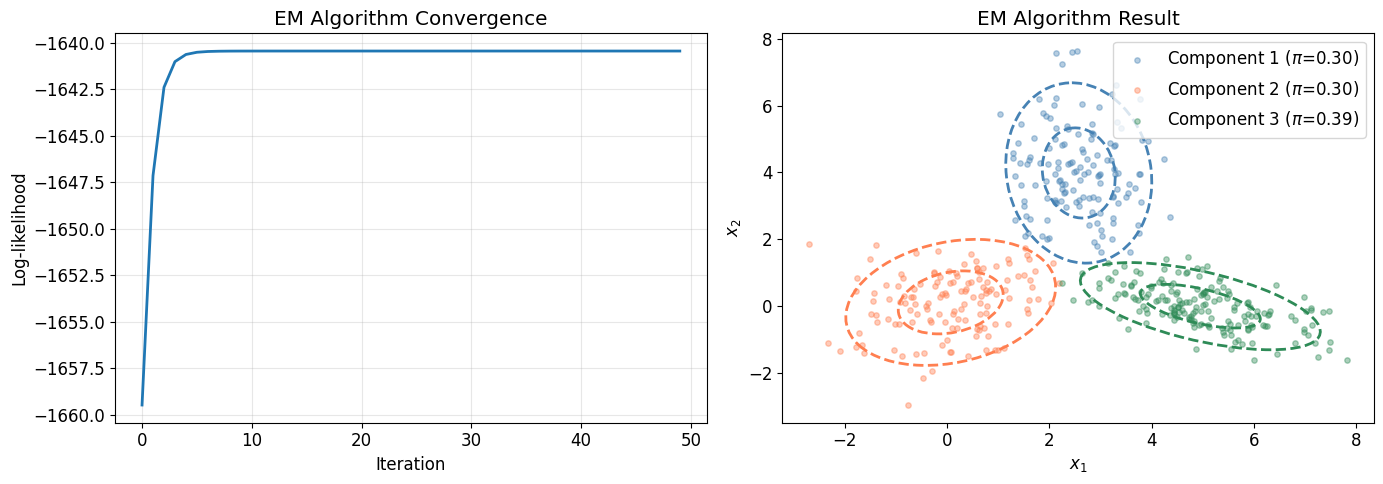

In [70]:
if 'll_history' in dir() and len(ll_history) > 0 and ll_history[0] is not None:
    from matplotlib.patches import Ellipse

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Log-likelihood
    ax = axes[0]
    ax.plot(ll_history, 'C0-', linewidth=2)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Log-likelihood')
    ax.set_title("EM Algorithm Convergence")
    ax.grid(True, alpha=0.3)

    # Clustering result
    ax = axes[1]
    z_em = np.argmax(resp_em, axis=1)
    colors_em = ['steelblue', 'coral', 'seagreen']

    for k in range(3):
        mask = z_em == k
        ax.scatter(X_gmm[mask, 0], X_gmm[mask, 1], c=colors_em[k], alpha=0.4,
                   s=15, label=f'Component {k+1} ($\pi$={weights_em[k]:.2f})')

        # Draw ellipses
        eigenvalues, eigenvectors = np.linalg.eigh(covs_em[k])
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        for n_std in [1, 2]:
            width = 2 * n_std * np.sqrt(eigenvalues[0])
            height = 2 * n_std * np.sqrt(eigenvalues[1])
            ellipse = Ellipse(means_em[k], width, height, angle=angle, fill=False,
                             color=colors_em[k], linewidth=2, linestyle='--')
            ax.add_patch(ellipse)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title("EM Algorithm Result")
    ax.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Complete the EM algorithm first!")

---
## Part 4: GMM vs. K-Means Comparison

The k-means algorithm is a limiting case of GMM where the covariances are spherical and identical, and the responsibilities become binary. Let's compare the two approaches on data with clusters of **different elliptical shapes**.

### Exercise 9: GMM vs. K-Means ★★★

Run the cell below, then answer the reflection questions.

(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(300, 2)


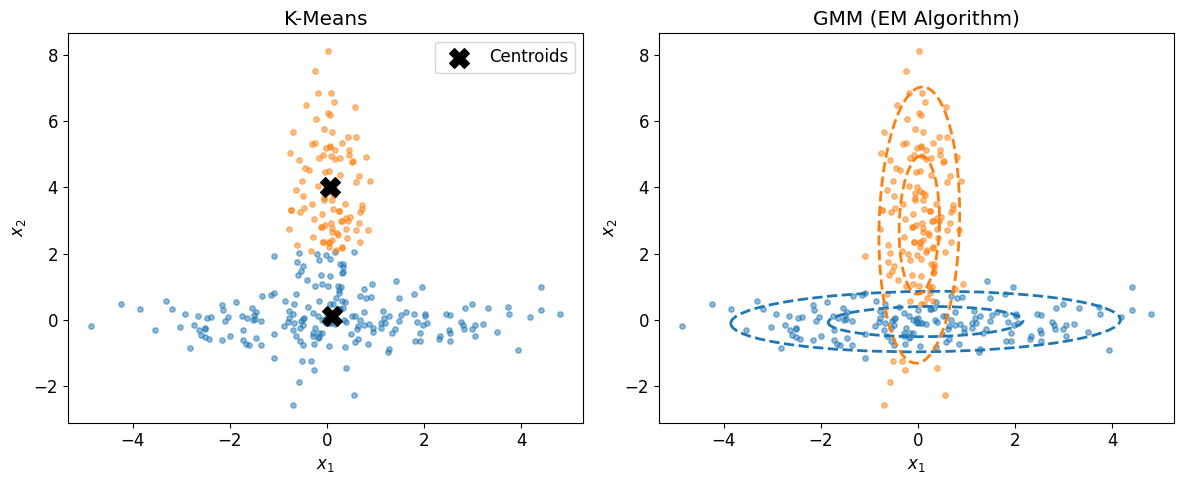

In [71]:
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

if 'll_history' in dir() and len(ll_history) > 0 and ll_history[0] is not None:
    # Data with elongated ellipses
    np.random.seed(123)
    X_ellipse = np.vstack([
        np.random.multivariate_normal([0, 0], [[4, 0], [0, 0.2]], 150),
        np.random.multivariate_normal([0, 3], [[0.2, 0], [0, 4]], 150),
    ])

    # K-means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    z_kmeans = kmeans.fit_predict(X_ellipse)

    # GMM (our implementation)
    w_cmp, m_cmp, c_cmp, r_cmp, _ = em_algorithm(X_ellipse, K=2, n_iterations=50, seed=42)
    z_gmm = np.argmax(r_cmp, axis=1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # K-means
    ax = axes[0]
    for k in range(2):
        mask = z_kmeans == k
        ax.scatter(X_ellipse[mask, 0], X_ellipse[mask, 1], c=f'C{k}', alpha=0.5, s=15)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
               c='black', marker='X', s=200, zorder=5, label='Centroids')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('K-Means')
    ax.legend()

    # GMM
    ax = axes[1]
    for k in range(2):
        mask = z_gmm == k
        ax.scatter(X_ellipse[mask, 0], X_ellipse[mask, 1], c=f'C{k}', alpha=0.5, s=15)

    for k in range(2):
        eigenvalues, eigenvectors = np.linalg.eigh(c_cmp[k])
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        for n_std in [1, 2]:
            width = 2 * n_std * np.sqrt(np.maximum(eigenvalues[0], 1e-6))
            height = 2 * n_std * np.sqrt(np.maximum(eigenvalues[1], 1e-6))
            ellipse = Ellipse(m_cmp[k], width, height, angle=angle, fill=False,
                             color=f'C{k}', linewidth=2, linestyle='--')
            ax.add_patch(ellipse)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('GMM (EM Algorithm)')

    plt.tight_layout()
    plt.show()
else:
    print("Complete the EM algorithm first!")

**Reflection questions:**
1. K-means partitions the space into regions bounded by linear boundaries (Voronoi diagram). Why is this problematic for elongated clusters?
2. GMM models each component with its own covariance matrix. What advantage does this give on data with varied shapes?
3. The soft responsibilities of GMM indicate assignment uncertainty. In which practical applications would this information be useful?

---
## Summary

In this practical exercise, you implemented two generative models:

1. **Naive Bayes** for text classification:
   - Estimation of priors $\hat{\pi}_c = N_c / N$ and conditional probabilities $\hat{\theta}_{dc}$ by maximum likelihood
   - Laplace smoothing to avoid zero probabilities
   - Prediction in log-space: $\hat{y} = \arg\max_c [\log \pi_c + \sum_d x_d \log \theta_{dc}]$

2. **Gaussian Mixture Model** for unsupervised clustering:
   - Multivariate Gaussian density and Mahalanobis distance
   - Responsibilities: soft membership probabilities $r_{nk} = p(z_n = k \mid \mathbf{x}_n)$
   - EM algorithm: alternating E-step (responsibilities) and M-step (weighted parameters)

Naive Bayes illustrates the generative approach in supervised classification: modeling $p(\mathbf{x} \mid y)$ for each class rather than $p(y \mid \mathbf{x})$ directly. GMM extends this idea to the unsupervised case, where the "classes" (components) are unknown and must be inferred by the EM algorithm.

---

**Going further**: [Chapter 6: Generative Probabilistic Models](https://pierrelux.github.io/mlbook/ch6_probabilistic_models)